## Load Data

In [ ]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow.keras as keras

# path to json file that stores MFCCs and genre labels for each processed segment
DATA_PATH = "/content/drive/MyDrive/surah_fatiha/data_surah_1.json"

def load_data(data_path):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    # convert lists to numpy arrays
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    print("Data succesfully loaded!")

    return  X, y


# Plot History

In [ ]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

# Prepare Dataset

In [ ]:
def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.
    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split
    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """

    # load data
    X, y = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test


# Build Model

In [ ]:
def build_model(input_shape):
    """Generates CNN model
    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # # 3rd conv layer
    # model.add(keras.layers.Conv2D(128, (2, 2), activation='relu'))
    # model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    # model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dropout(0.2))

    # output layer
    model.add(keras.layers.Dense(28, activation='softmax'))

    return model

In [ ]:
def predict(model, X, y):
    """Predict a single sample using the trained model
    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))


Data succesfully loaded!
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 7, 11, 32)         320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 6, 32)         0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 4, 6, 32)         128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 4, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 2, 64)         0         
 2D)                                                             
                               

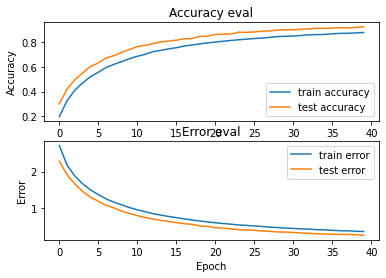

876/876 - 2s - loss: 0.2692 - accuracy: 0.9225 - 2s/epoch - 3ms/step

Test accuracy: 0.9224867224693298
1/1 [==============================] - 0s 236ms/step
Target: 16, Predicted label: [16]


In [ ]:
if __name__ == "__main__":

    # get train, validation, test splits
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)
    # create network
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    model = build_model(input_shape)

    # compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    # train model
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=40)

    # plot accuracy/error for training and validation
    plot_history(history)

    # evaluate model on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

    # pick a sample to predict from the test set
    X_to_predict = X_test[100]
    y_to_predict = y_test[100]

    # predict sample
    predict(model, X_to_predict, y_to_predict)


In [ ]:
SAVED_MODEL_PATH = "model.h5"
model.save(SAVED_MODEL_PATH)


In [ ]:
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
    _mapping = {
    1:"Bis'mi",
    2:"Al-lahi",
    3:"Al-rahmaani",
    4:"Al-raheemi",
    5:"Alhamdu",
    6:"lillaahi",
    7:"Rabbil",
    8:"aalameen",
    9:"Ar-Rahmaan",
    10:"Ar-Raheem",
    11:"Maaliki",
    12:"Yumid",
    13:"Diin",
    14:"Iyyaka",
    15:"Na'abudu",
    16:"Iyyaka",
    17:"Nasta'een",
    18:"Ihdinas",
    19:"Siraatal",
    20:"Mustaqeem",
    21:"Siraatal",
    22:"Ladheena",
    23:"An'amta",
    24:"Alaihim",
    25:"Ghayril",
    26:"Maghdubi",
    27:"Alaihim",
    28:"Wala al-dalina"}

In [ ]:
SAMPLE_RATE = 22050
TRACK_DURATION = 2 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION
file = '/content/003.wav'

def save_mfcc(file_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    mfcc_lst = []
    # we divide the track into 5 segments
    # to calculate sample per segment - we need to know the number of samples per track (which is the sample rate * the track duration )
    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

    # process all segments of audio file
    for d in range(num_segments):

        # calculate start and finish sample for current segment
        start = samples_per_segment * d
        finish = start + samples_per_segment

        # extract mfcc - for each segment of signal
        mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
        mfcc = mfcc.T

        # store only mfcc feature with expected number of vectors
        if len(mfcc) == num_mfcc_vectors_per_segment:
            mfcc_lst.append(mfcc.tolist())
    return mfcc_lst

In [ ]:
import librosa
import tensorflow as tf
import numpy as np
import math
SAVED_MODEL_PATH = "model.h5"
SAMPLE_RATE = 22050
TRACK_DURATION = 2 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

class _Keyword_Spotting_Service:
    """Singleton class for keyword spotting inference with trained models.

    :param model: Trained model
    """
    
    model = None
    _mapping = [
    "Bis'mi",
    "Al-lahi",
    "Al-rahmaani",
    "Al-raheemi",
    "Alhamdu",
    "lillaahi",
    "Rabbil",
    "aalameen",
    "Ar-Rahmaan",
    "Ar-Raheem",
    "Maaliki",
    "Yumid",
    "Diin",
    "Iyyaka",
    "Na'abudu",
    "Iyyaka",
    "Nasta'een",
    "Ihdinas",
    "Siraatal",
    "Mustaqeem",
    "Siraatal",
    "Ladheena",
    "An'amta",
    "Alaihim",
    "Ghayril",
    "Maghdubi",
    "Alaihim",
    "Wala al-dalina"
    ]
    _instance = None


    def predict(self, file_path):
        """

        :param file_path (str): Path to audio file to predict
        :return predicted_keyword (str): Keyword predicted by the model
        """

        # extract MFCC
        MFCCs = np.array([[-208.88369750976562, 173.29107666015625, -13.837435722351074, 14.191682815551758, -63.53321838378906, 9.908905029296875, -34.52302932739258, -7.0630083084106445, -11.072137832641602, 7.897786617279053, 12.635082244873047, -1.260940670967102, -14.440847396850586], [-175.98480224609375, 167.88204956054688, -30.289634704589844, 16.558849334716797, -79.59504699707031, 20.788333892822266, -40.25474548339844, -13.491707801818848, -13.442451477050781, 3.592095375061035, 10.45197868347168, -4.956630706787109, -13.133575439453125], [-177.2965545654297, 140.26446533203125, -42.05194091796875, 15.591264724731445, -79.16682434082031, 35.215572357177734, -48.15814971923828, -7.50286865234375, -7.240591049194336, 2.553539276123047, 9.138029098510742, -3.4423742294311523, -6.37964391708374], [-185.95509338378906, 124.90979766845703, -38.33936309814453, 22.440292358398438, -72.64540100097656, 47.9068717956543, -48.2619514465332, 1.8480926752090454, -3.999704360961914, -0.6501009464263916, 5.425509929656982, -6.084258079528809, -1.652677059173584], [-208.18551635742188, 112.87013244628906, -27.377513885498047, 31.67277717590332, -69.78677368164062, 45.79389953613281, -52.503211975097656, 0.9649603962898254, -7.219353199005127, -0.7659001350402832, 2.2723073959350586, -12.100591659545898, 0.217118501663208], [-190.88275146484375, 135.42083740234375, -31.51664924621582, 30.064231872558594, -69.34258270263672, 30.436262130737305, -56.083526611328125, -15.316060066223145, -16.722349166870117, 1.2809876203536987, -9.884056091308594, -20.502822875976562, -3.5870373249053955], [-207.81170654296875, 148.36880493164062, -37.037811279296875, 37.063602447509766, -56.117095947265625, 16.19550132751465, -35.421043395996094, -21.73065948486328, -18.389490127563477, 2.5057411193847656, -17.75062370300293, -18.73059844970703, -5.083065509796143], [-245.4512939453125, 137.54977416992188, -36.500579833984375, 54.88190841674805, -53.14923095703125, 13.605981826782227, -8.012560844421387, -28.28583526611328, -8.899959564208984, -3.0852625370025635, -13.78553581237793, -14.101425170898438, -10.775411605834961], [-236.1332244873047, 140.26885986328125, -4.87683629989624, 55.43954086303711, -48.025421142578125, 16.675363540649414, 1.0351996421813965, -34.397491455078125, -10.365550994873047, -0.5815303325653076, -10.888479232788086, -3.4156363010406494, -5.683342933654785]])

        # we need a 4-dim array to feed to the model for prediction: (# samples, # time steps, # coefficients, 1)
        MFCCs = MFCCs[np.newaxis, ..., np.newaxis]

        # get the predicted label
        predictions = self.model.predict(MFCCs) # a 2d array [[]]
        predicted_index = np.argmax(predictions)
        # index return the index which has highest score
        predicted_keyword = self._mapping[predicted_index]
        # print('prediction',predicted_index,predicted_keyword)
        return predicted_keyword


    def preprocess(self, file_path, num_mfcc=13, n_fft=2048, hop_length=512,num_segments=5):
        mfcc_lst = []
        # we divide the track into 5 segments
        # to calculate sample per segment - we need to know the number of samples per track (which is the sample rate * the track duration )
        samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
        num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

        signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

        # process all segments of audio file
        for d in range(num_segments):

            # calculate start and finish sample for current segment
            start = samples_per_segment * d
            finish = start + samples_per_segment

            # extract mfcc - for each segment of signal
            mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
            mfcc = mfcc.T

            # store only mfcc feature with expected number of vectors
            if len(mfcc) == num_mfcc_vectors_per_segment:
                mfcc_lst.append(mfcc.tolist())
        return mfcc_lst


def Keyword_Spotting_Service():
    """Factory function for Keyword_Spotting_Service class.

    :return _Keyword_Spotting_Service._instance (_Keyword_Spotting_Service):
    """

    # ensure an instance is created only the first time the factory function is called
    if _Keyword_Spotting_Service._instance is None:
        _Keyword_Spotting_Service._instance = _Keyword_Spotting_Service()
        _Keyword_Spotting_Service.model = tf.keras.models.load_model(SAVED_MODEL_PATH)
    return _Keyword_Spotting_Service._instance




if __name__ == "__main__":

    # create 2 instances of the keyword spotting service
    kss = Keyword_Spotting_Service()
    kss1 = Keyword_Spotting_Service()

    # check that different instances of the keyword spotting service point back to the same object (singleton)
    assert kss is kss1

    # make a prediction
    keyword = kss.predict("003.wav")
    print(keyword)

1/1 [==============================] - 0s 318ms/step
Alhamdu
